This example loads the prescription of the afocal telescope for the PICTURE-C balloon.
For more detailed explanations see Douglas et al. Proc. SPIE 2015 and Mendillo et al. Proc. SPIE 2015.

In [27]:
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt

from astropy import units as u
from astropy.io import fits

import poppy
from poppy import fresnel
import logging

try:
    from IPython.core.debugger import Tracer; stop = Tracer()
except:
    pass

logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.WARN, datefmt='%I:%M:%S')


In [38]:
npix=256
#import data in inches:
inches=u.imperial.inch
sys=np.genfromtxt('data/rx_afocal_old.csv',delimiter=',', 
                  dtype="S10,S10,f8,f8,f8,f8,f8,f8,f8,f8,f8,f8,f8,f8,S5,S5,",
                  skip_header=16,names=True)

primary_r=sys['Radius_in'][0]*inches
primary_fl=sys['Focal_Length_in'][0]*inches

pic_c_sys = poppy.FresnelOpticalSystem(pupil_diameter=2*primary_r, npix=npix,beam_ratio=.34)

entrance=poppy.CircularAperture(radius=primary_r.to(u.m).value)
pic_c_sys.add_optic(entrance)
for n_optic,optic in enumerate(sys):

    fl=optic['Focal_Length_in'] *inches
    
    #roll the distances by one, and don't propagate after the last optic
    # Since the POPPY system convention is the location of the optic 
    #and the PICSIM convention is the distance after the optic,
    dz = sys[n_optic]['Distance_in'] * inches

    if (n_optic == 0): 
        dz_sys = 0*u.m
    else:
        dz_sys = sys[n_optic-1]['Distance_in'] * inches

    if fl !=0:
        gl=fresnel.GaussianLens(fl,name=optic['Name'])
        pic_c_sys.add_optic(gl,distance=dz_sys)
        pic_c_sys.add_optic(poppy.CircularAperture(radius=(optic['Radius_in']*inches).to(u.m).value))
    elif n_optic == sys.size-1:
        #if focal lengths worked, this could be an image
        pic_c_sys.add_optic(poppy.ScalarTransmission(planetype=poppy.PlaneType.intermediate,
                                                     name=optic['Name']), distance=dz_sys)
        #image plane doesn't get a circular aperture
    else:
        pic_c_sys.add_optic(poppy.ScalarTransmission(planetype=poppy.PlaneType.intermediate,
                                                     name=optic['Name']), distance=dz_sys)
        pic_c_sys.add_optic(poppy.CircularAperture(radius=(optic['Radius_in']*inches).to(u.m).value))
    #mask the beam by the size of the optic

    

In [39]:
%timeit pic_c_sys.calcPSF(wavelength=675e-9,display_intermediates=False,return_intermediates=False)


1 loops, best of 3: 5.03 s per loop


In [40]:
#should take the same amount of time if returning intermediate arrays
%time pic_c_sys.calcPSF(wavelength=675e-9,display_intermediates=False,return_intermediates=True)
psf,waves=pic_c_sys.calcPSF(wavelength=675e-9,display_intermediates=False,return_intermediates=True)


CPU times: user 4.87 s, sys: 879 ms, total: 5.75 s
Wall time: 5.76 s


CPU times: user 19.4 s, sys: 1.98 s, total: 21.4 s
Wall time: 21.4 s


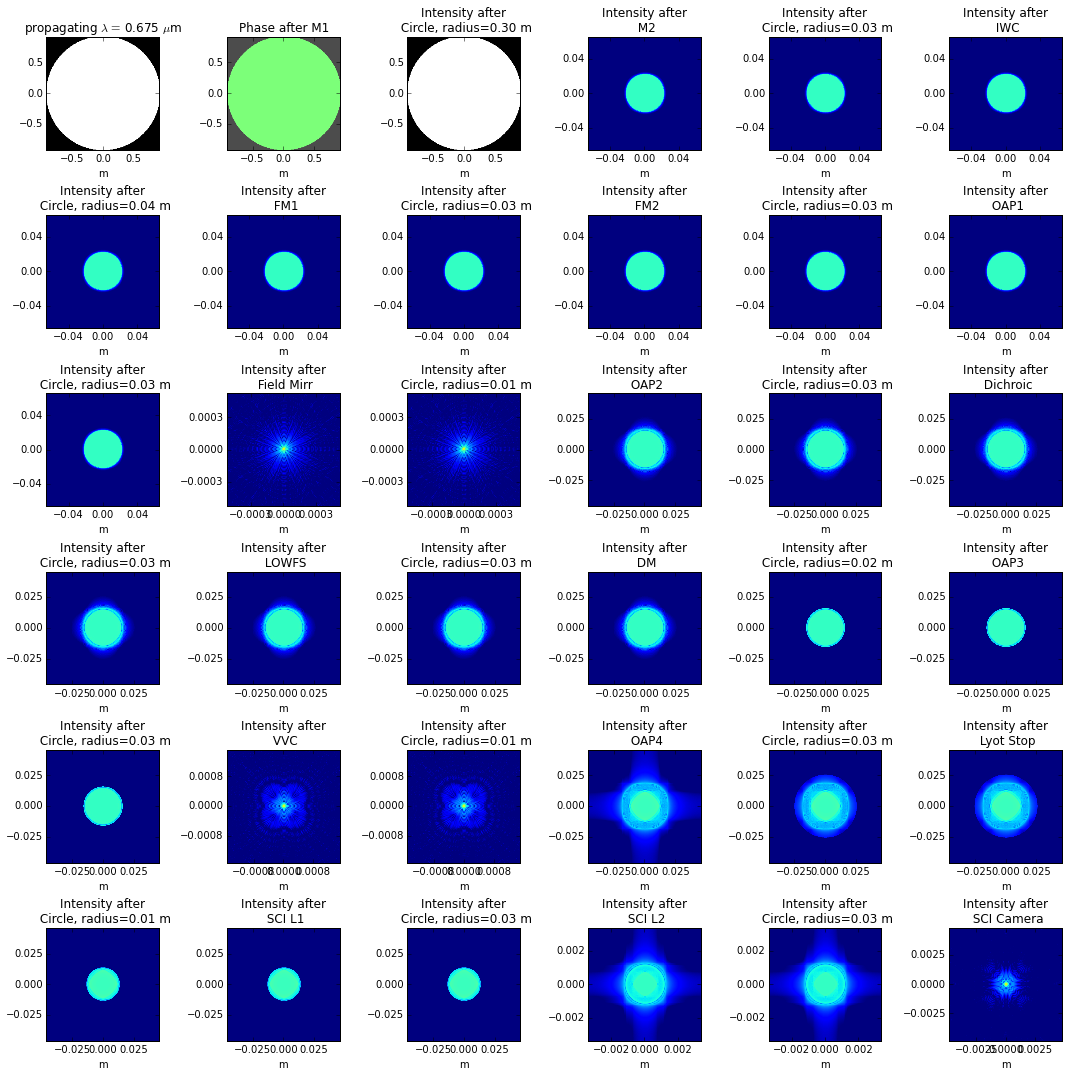

In [41]:
#takes much longer to also plot each surface:
plt.figure(figsize=[15,15])
%time pic_c_sys.calcPSF(wavelength=675e-9,display_intermediates=True,return_intermediates=False)
plt.tight_layout()

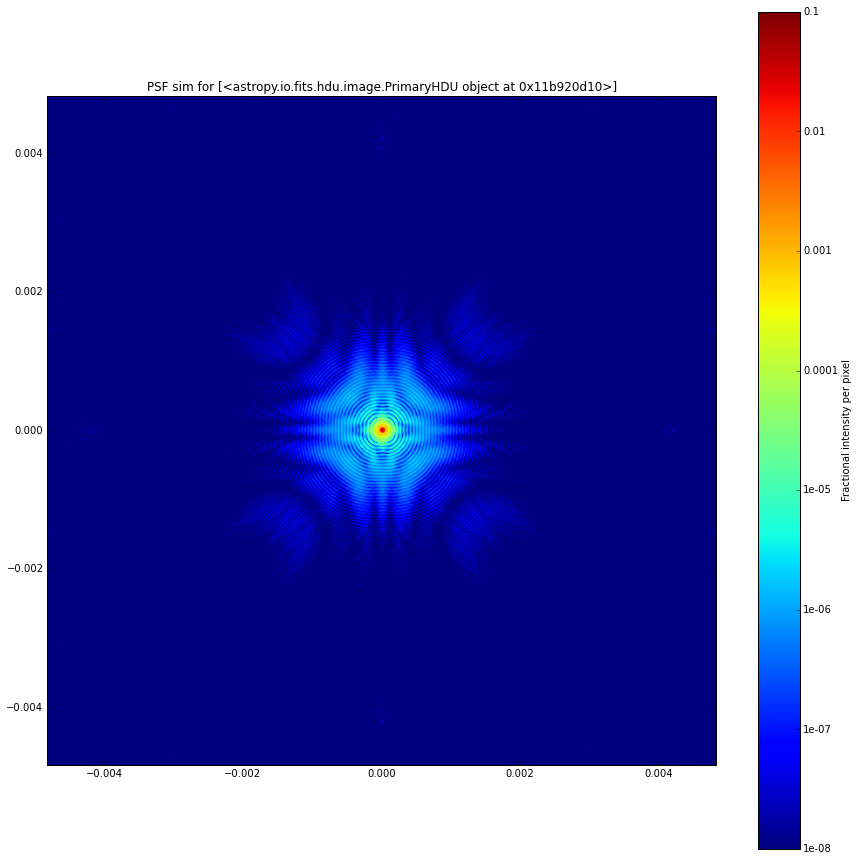

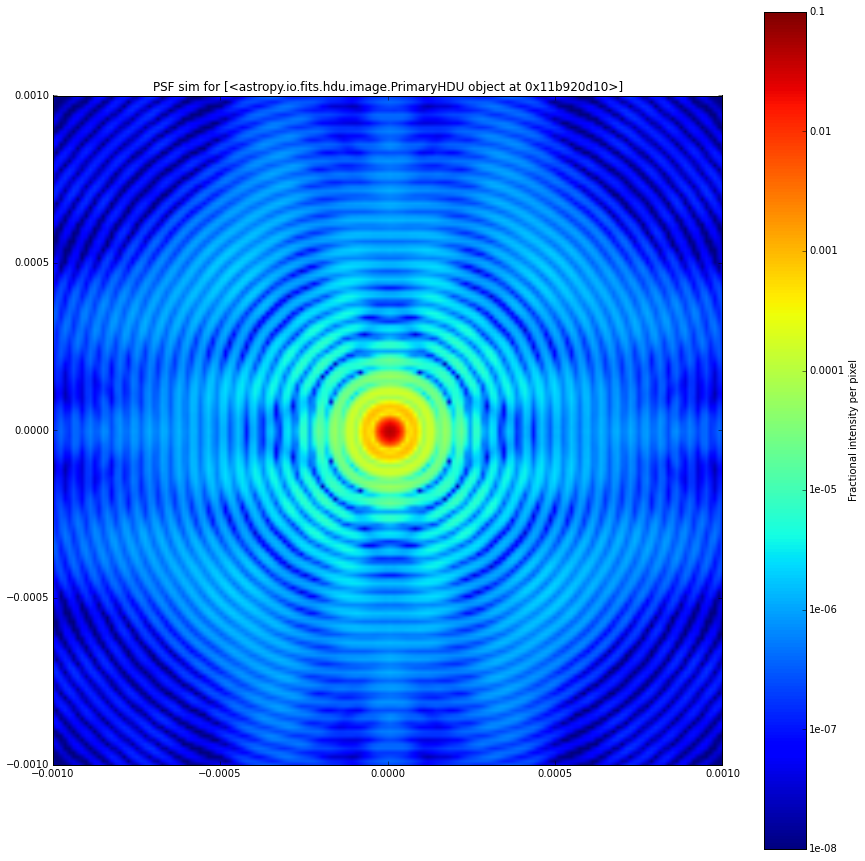

In [42]:
plt.figure(figsize=[15,15])

poppy.display_PSF(psf)

plt.figure(figsize=[15,15])

poppy.display_PSF(psf,imagecrop=.002)